In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 1.2MB 37.6MB/s 
     |████████████████████████████████| 194kB 52.5MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
Mounted at /content/gdrive


# Interpretation von CNNs mittels CAM

In [ ]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.126551,0.016537,0.006089,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.055170,0.016151,0.005413,01:03


In [ ]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))

In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [ ]:
with torch.no_grad(): output = learn.model.eval()(x)

In [ ]:
act = hook_output.stored[0]

In [ ]:
F.softmax(output, dim=-1)

tensor([[1.5928e-10, 1.0000e+00]], device='cuda:0')

In [ ]:
dls.vocab

[False, True]

In [ ]:
x.shape

(1, 3, 224, 224)

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

Tutorial zu Python's einsum: [https://www.gormanalysis.com/blog/python-numpy-for-your-grandma-6-2-einsum/](https://www.gormanalysis.com/blog/python-numpy-for-your-grandma-6-2-einsum/)

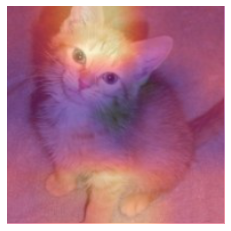

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
hook.remove()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

## Gradient CAM

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

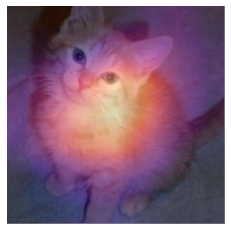

In [ ]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

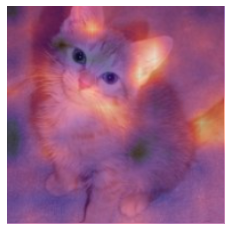

In [ ]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');